# 4. Árboles de Decisión

Veremos árboles de decisión y los conceptos subyacentes asociados.

Haremos ejemplos de juguete y con datos generados artificialmente.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Entropía y Ganancia de Información

### Entropía

Definamos entropía para una distribución probabilista:

$$H(Y) = - \sum_{i=1}^k P(Y = y_i) log_2 P(Y = y_i)$$

In [3]:
def entropy(probs):
    return - np.sum(probs * np.log2(probs))

Veamos posibles entropías para el problema de tirar una moneda adulterada:

In [4]:
entropy(np.array([0.5, 0.5]))

1.0

In [7]:
entropy(np.array([0.01, 0.99]))

0.08079313589591118

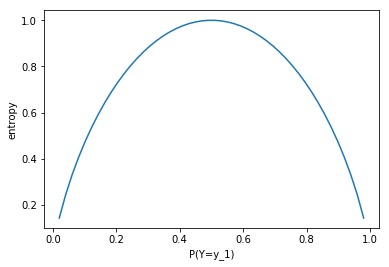

In [8]:
X = np.linspace(0, 1)[1:-1]
plt.plot(X, [entropy([x, 1-x]) for x in X])
plt.xlabel('P(Y=y_1)')
plt.ylabel('entropy')
plt.show()

La entropía se puede interpretar como la cantidad de bits necesarias para codificar una predicción.
En el caso de dos monedas, tenemos cuatro resultados posibles. Ejemplos:

In [9]:
entropy(np.array([0.25, 0.25, 0.25, 0.25]))

2.0

In [10]:
entropy(np.array([0.48, 0.48, 0.01, 0.01]))

1.1494150652869202

### Entropía de un Dataset

Un dataset define una distribución empírica. La entropía del dataset es entones la entropía de la distribución asociada. Definamos el cálculo de la distribución, y luego redefinamos entropía:

In [11]:
def probs(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return probs

In [12]:
y_true = np.array([1, 1, 1, 1, 1, -1])

In [13]:
probs(y_true)

array([0.16666667, 0.83333333])

In [14]:
def entropy(y):
    p = probs(y)
    return - np.sum(p * np.log2(p))

In [15]:
entropy(y_true)

0.6500224216483541

### Entropía Condicional

Definamos entropía condicional:

$$H(Y|X) = - \sum_{j=1}^v P(X = x_j) \sum_{i=1}^k P(Y = y_i | X = x_j) log_2 P(Y = y_i | X = x_j)$$

Equivalentemente, 

$$H(Y|X) = \sum_{j=1}^v P(X = x_j) H(Y|X = x_j)$$

Tomaremos $X$ binaria ($v=2$), por lo que la entropía condicional tendrá sólo dos términos.


In [16]:
def cond_entropy(y1, y2):
    size = y1.shape[0] + y2.shape[0]
    return y1.shape[0] / size * entropy(y1) + y2.shape[0] / size * entropy(y2) 

In [17]:
cond_entropy(np.array([1,1,1,1]), np.array([1,-1]))

0.3333333333333333

### Ganancia de Información

La ganancia de información será simplemente la diferencia entre entropía y entropía condicional:

In [19]:
def information_gain(y1, y2):
    y = np.concatenate((y1,y2))
    return entropy(y) - cond_entropy(y1,y2)

In [20]:
information_gain(np.array([1,1,1,1]), np.array([1,-1]))  # x1

0.3166890883150208

In [21]:
information_gain(np.array([1,1,1]), np.array([1,1,-1]))  # x2

0.19087450462110933

## Datos Sintéticos No Linealmente Separables

Haremos algunos experimentos con datos generados sintéticamente. Estos datos serán no linealmente separables.

Ejemplos típicos de datos no linealmente separables son los de tipo "OR", "AND" y "XOR". Usaremos datos de tipo "OR" para este ejemplo.



In [22]:
size = 200

In [80]:
np.random.seed(0)
X = np.random.randn(size, 2)
y_true = np.logical_or(X[:, 0] > 0, X[:, 1] > 0)    # datos "OR"
#y_true = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)  # datos "XOR"
#y_true = np.logical_and(X[:, 0] > 0, X[:, 1] > 0)  # datos "AND"
y_true = y_true.astype(int)
y_true[y_true == 0] = -1

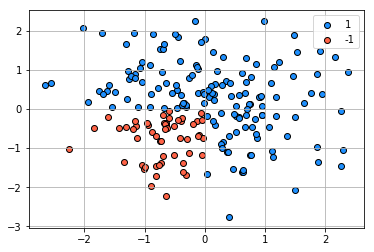

In [81]:
plt.scatter(X[y_true==1, 0], X[y_true==1, 1], color="dodgerblue", edgecolors='k', label="1")
plt.scatter(X[y_true==-1, 0], X[y_true==-1, 1], color="tomato", edgecolors='k', label="-1")
plt.grid()
plt.legend()
plt.show()

### División en Entrenamiento y Evaluación

Separemos la mitad para entrenamiento y la otra para evaluación.

In [32]:
train_size = 100
test_size = size - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_true[:train_size], y_true[train_size:]

In [33]:
X_train.shape, X_test.shape

((100, 2), (100, 2))

### Clasificación Lineal

Veamos qué tan mal anda un clasificador lineal sobre estos datos.

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train);

/home/francolq/.virtualenvs/pln/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


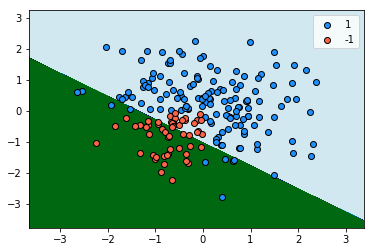

In [35]:
from utils import plot_decision_boundary

plot_decision_boundary(lambda x: model.predict(x), X, y_true)

Calculemos la calidad de la predicción en entrenamiento y evaluación:

In [36]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 0.91
Test accuracy: 0.8


### Nota al Margen: Induciendo Separabilidad Lineal

Muchas veces se pueden convertir datos no linealmente separables en datos separables (o casi) mediante la introducción de nuevos atributos que combinan los atributos existentes.
Un ejemplo de estos son los atributos polinomiales.

Aquí lo haremos con datos "OR", pero la diferencia es mucho más notable con datos de tipo "XOR".

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pre = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train2 = pre.fit_transform(X_train)

In [40]:
X_train.shape, X_train2.shape

((100, 2), (100, 3))

Grafiquemos:

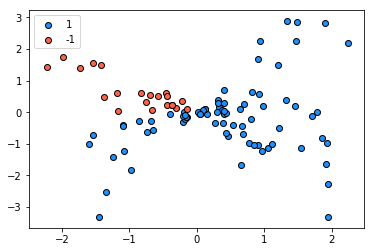

In [41]:
plt.scatter(X_train2[y_train==1, 1], X_train2[y_train==1, 2], color="dodgerblue", edgecolors='k', label="1")
plt.scatter(X_train2[y_train==-1, 1], X_train2[y_train==-1, 2], color="tomato", edgecolors='k', label="-1")
plt.legend()
plt.show()

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    LogisticRegression()
)
model.fit(X_train, y_train);

/home/francolq/.virtualenvs/pln/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 0.97
Test accuracy: 0.86


### Entropía y Valores Reales

Calculemos la entropía inicial, y veamos cómo condicionar la entropía sobre variales reales (i.e. no categóricas)

In [45]:
probs(y_train)

array([0.21, 0.79])

In [46]:
entropy(y_train)

0.7414827399312737

Para hacer una división sobre una variable real usaremos un valor "threshold" (umbral):

In [47]:
def split(X, y, i, threshold):
    y1 = y[X[:, i] > threshold]
    y2 = y[X[:, i] <= threshold]
    return y1, y2

In [48]:
y1, y2 = split(X_train, y_train, 0, 0.0)

In [49]:
y1,y2

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]),
 array([ 1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,
         1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
         1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1,
        -1]))

In [50]:
entropy(y1), entropy(y2)

(-0.0, 0.9731560354421095)

In [51]:
cond_entropy(y1, y2)

0.506041138429897

In [52]:
information_gain(y1,y2)

0.23544160150137672

### Buscando la Mejor División

Ilustraremos un paso en la construcción del árbol de decisión.

Probemos muchos threshold para ambas variables y seleccionemos la mejor división.

En este caso buscaremos en una grilla uniforme de valores, pero existen técnicas mejores.

In [53]:
np.linspace(-2.5, 2.5, 11)

array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5])

In [54]:
best_ig = 0

for i in [0, 1]:
    for threshold in np.linspace(-2.5, 2.5, 11):
        y1, y2 = split(X_train, y_train, i, threshold)
        ig = information_gain(y1, y2)
        print(f'i={i}\tthreshold={threshold:+00.2f}\tig={ig:.2f}')
        
        if ig >= best_ig:
            best_ig = ig
            best_feature = i
            best_threshold = threshold

print('Mejor división:')
print(f'feature={best_feature}, threshold={best_threshold}, ig={best_ig:00.2f}')


i=0	threshold=-2.50	ig=0.00
i=0	threshold=-2.00	ig=0.00
i=0	threshold=-1.50	ig=0.00
i=0	threshold=-1.00	ig=0.00
i=0	threshold=-0.50	ig=0.12
i=0	threshold=+0.00	ig=0.24
i=0	threshold=+0.50	ig=0.13
i=0	threshold=+1.00	ig=0.06
i=0	threshold=+1.50	ig=0.03
i=0	threshold=+2.00	ig=0.01
i=0	threshold=+2.50	ig=0.00
i=1	threshold=-2.50	ig=0.00
i=1	threshold=-2.00	ig=0.02
i=1	threshold=-1.50	ig=0.05
i=1	threshold=-1.00	ig=0.06
i=1	threshold=-0.50	ig=0.12
i=1	threshold=+0.00	ig=0.32
i=1	threshold=+0.50	ig=0.15
i=1	threshold=+1.00	ig=0.07
i=1	threshold=+1.50	ig=0.04
i=1	threshold=+2.00	ig=0.00
i=1	threshold=+2.50	ig=0.00
Mejor división:
feature=1, threshold=0.0, ig=0.32


Dividamos los datos de acuerdo a esta frontera:

In [55]:
y1, y2 = split(X_train, y_train, best_feature, best_threshold)

Con esta división, la entropía baja considerablemente:

In [56]:
entropy(y_train)

0.7414827399312737

In [57]:
cond_entropy(y1, y2)

0.42

## Árbol de Decisión con Scikit-learn

Aprendamos un árbol de decisión usando scikit-learn. Para ello usaremos la clase [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):


In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Ahora predecimos y evaluamos:

In [72]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 1.0
Test accuracy: 0.97


Dibujamos la frontera de decisión:

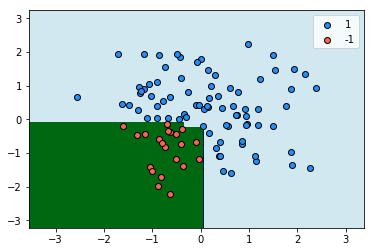

In [74]:
from utils import plot_decision_boundary

plot_decision_boundary(lambda x: clf.predict(x), X_train, y_train)

También podemos inspeccionar el árbol:

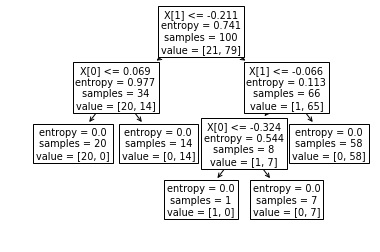

In [75]:
from sklearn.tree import plot_tree

plot_tree(clf);

In [76]:
entropy(y_train)

0.7414827399312737

## Ejercicios

1. Probar todos los experimentos con un dataset de tipo "XOR". ¿Qué sucede al decidir la división en el primer nivel del árbol?

## Referencias

Scikit-learn:

- [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [User Guide: Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
